In [1]:
import re
import json

import requests

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
teams = [
  'nyy',
  'oak',
]

seasons = [
  '2003',
  '2022',
]

def get_team_games(team, season, half = 1):
    response = requests.get(f'https://www.espn.com/mlb/team/schedule/_/name/{team}/season/{season}/seasontype/2/half/{half}')
    bs = BeautifulSoup(response.content)

    games = []
    for link in bs.select('tbody.Table__TBODY .AnchorLink'):
        results = re.search(r'https://www.espn.com/mlb/game/_/gameId/(\d+)', link['href'])
        if results is not None:
            games.append(results.group(1))

    return games

## 2nd half of 2005 w/ pitch coords
games = get_team_games('oak', '2022')
games[:5]

['401354261', '401354274', '401354289', '401354300', '401354316']

In [3]:
def get_game_pbp_data(game_id):
    response = requests.get(f'https://www.espn.com/mlb/playbyplay/_/gameId/{game_id}')
    bs = BeautifulSoup(response.content)

    scripts = bs.select('script')
    json_blobs = [ script for script in scripts if script.text.startswith("window['__espnfitt__']=") ]
    if len(json_blobs) == 0:
        return []

    json_blob = json_blobs[0].text
    obj = json.loads(json_blob[len('window[\'__espnfitt__\']='):-1])
    return obj['page']['content']['gamepackage']['pbp']

pbp = get_game_pbp_data(games[0])
pbp[0]

{'atBatTeam': {'abbrev': 'OAK',
  'logo': 'https://a.espncdn.com/i/teamlogos/mlb/500/oak.png',
  'name': 'Athletics'},
 'awayTeamShortName': 'OAK',
 'homeTeamShortName': 'PHI',
 'errors': 0,
 'hits': 0,
 'period': {'number': 1, 'type': 'Top'},
 'runs': '0',
 'dsc': 'A. Nola pitching for PHI',
 'plays': [{'dsc': 'Kemp grounded out to second.',
   'id': '4013542610001990057',
   'isAway': True,
   'isScoringPlay': False,
   'awayScore': 0,
   'homeScore': 0,
   'defaultOpen': True,
   'pitches': [{'count': 1,
     'dsc': 'Strike Looking',
     'id': '4013542610001020036',
     'ptchCoords': {'x': 150, 'y': 175},
     'ptchDsc': 'Four-seam FB',
     'rslt': 'strike',
     'vlcty': 93,
     'evnts': {'onBase': [False, False, False]}},
    {'count': 2,
     'dsc': 'Ground Out',
     'id': '4013542610001030024',
     'ptchCoords': {'x': 144, 'y': 187},
     'ptchDsc': 'Knuckle Curve',
     'rslt': 'play',
     'vlcty': 79,
     'hitCoords': {'x': 153, 'y': 157},
     'evnts': {'onBase': [Fal

In [4]:
def parse_mlb_pbp_data(pbp):
    pitcher_tracker = {}

    observations = []
    for record in pbp:
        period = record['period']
        atBat = record['atBatTeam']['abbrev']
        period.update({ 'atBat': atBat })

        pitcher = re.search(r'(.+?) pitching', record['dsc'] if 'dsc' in record else '')
        if pitcher is not None:
            pitcher_tracker[atBat] = pitcher.group(1)

        observation = {
            'period': period,
            'batters': []
        }

        for play in record['plays']:
            if 'isPitcherChange' in play and play['isPitcherChange']:
                desc =  play['dsc'] if 'dsc' in play else 'NO-IDEA pitching'
                pitcher_tracker[atBat] = re.search(r'(.+?) pitching', desc).group(1)

            if 'pitches' in play:
                observation['batters'].append({
                    'pitcher': pitcher_tracker[atBat],
                    'dsc': play['dsc'],
                    'pitches': [ 
                        {
                            'desc': pitch['dsc'],
                            'coords': pitch['ptchCoords'] if 'ptchCoords' in pitch else {'x': -1, 'y': -1},
                            'pitch': pitch['ptchDsc'] if 'ptchDsc' in pitch else '',
                            'call': pitch['rslt'],
                            'vel': pitch['vlcty'] if 'vlcty' in pitch else '',
                            'bases': [ int(i) for i in pitch['evnts']['onBase'] ] if 'evnts' in pitch and 'onBase' in pitch['evnts'] else [0, 0, 0]
                        }
                        for pitch in play['pitches']
                    ],
                })

        observations.append(observation)

    return {
        'half-innings': observations,
    }

game = parse_mlb_pbp_data(pbp)

In [5]:
game['half-innings'][13]

{'period': {'number': 7, 'type': 'Bottom', 'atBat': 'PHI'},
 'batters': [{'pitcher': 'D. Acevedo',
   'dsc': 'Realmuto struck out looking.',
   'pitches': [{'desc': 'Strike Looking',
     'coords': {'x': 100, 'y': 153},
     'pitch': 'Four-seam FB',
     'call': 'strike',
     'vel': 92,
     'bases': [0, 0, 0]},
    {'desc': 'Foul Ball',
     'coords': {'x': 113, 'y': 169},
     'pitch': 'Slider',
     'call': 'strike',
     'vel': 86,
     'bases': [0, 0, 0]},
    {'desc': 'Strike Looking',
     'coords': {'x': 110, 'y': 184},
     'pitch': 'Changeup',
     'call': 'strike',
     'vel': 85,
     'bases': [0, 0, 0]}]},
  {'pitcher': 'D. Acevedo',
   'dsc': 'Harper walked.',
   'pitches': [{'desc': 'Ball',
     'coords': {'x': 137, 'y': 118},
     'pitch': 'Four-seam FB',
     'call': 'ball',
     'vel': 93,
     'bases': [0, 0, 0]},
    {'desc': 'Ball',
     'coords': {'x': 115, 'y': 209},
     'pitch': 'Changeup',
     'call': 'ball',
     'vel': 85,
     'bases': [0, 0, 0]},
    {'d

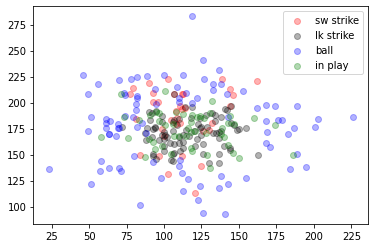

In [6]:
swinging_strikes, looking_strikes, balls, play = [], [], [], []

for item in game['half-innings']:
    for batter in item['batters']:
        for pitch in batter['pitches']:
            result = pitch['call']
            x = pitch['coords']['x']
            y = pitch['coords']['y']
            coords = [x, y]

            if result == 'play':
                play.append(coords)
            if result == 'ball':
                balls.append(coords)
            if result == 'strike':
                if 'Swinging' in pitch['desc']:
                    swinging_strikes.append(coords)
                else:
                    looking_strikes.append(coords)

plt.scatter(x=[i[0] for i in swinging_strikes], y=[i[1] for i in swinging_strikes], label='sw strike', c='r', alpha=0.3)
plt.scatter(x=[i[0] for i in looking_strikes], y=[i[1] for i in looking_strikes], label='lk strike', c='k', alpha=0.3)
plt.scatter(x=[i[0] for i in balls], y=[i[1] for i in balls], label='ball', c='b', alpha=0.3)
plt.scatter(x=[i[0] for i in play], y=[i[1] for i in play], label='in play', c='g', alpha=0.3)

plt.legend(loc='upper right')
plt.show()